In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import ParameterGrid  

## Description:
The Student Performance Dataset is a dataset designed to examine the factors influencing academic student performance. The dataset consists of 10,000 student records, with each record containing information about various predictors and a performance index.### Features:
Hours urs Studied: The total number of hours spent studying by each student.
Previous Scores: The scores obtained by students in previous tests.
Extracurricular Activities: Whether the student participates in extracurricular activities (Yes or No).
Sleep Hours: The average number of hours of sleep the student had per day.
Sample Question Papers Practiced: The number of sample question papers the student pr
a### Target variable:Vriable:

Performance Index: A measure of the overall performance of each student. The performance index represents the student's academic performance and has been rounded to the nearest integer. The index ranges from 10 to 100, with higher values indicating better performance.
The dataset aims to provide insights into the relationship between the predictor variables and the performance index. Researchers and data analysts can use this dataset to explore the impact of studying hours, previous scores, extracurricular activities, sleep hours, and sample question papers on student performance.

In [3]:
df= pd.read_csv("C:/Users/USER/Downloads/archive (11)/Student_Performance.csv")

In [4]:
df.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


In [5]:
df.columns

Index(['Hours Studied', 'Previous Scores', 'Extracurricular Activities',
       'Sleep Hours', 'Sample Question Papers Practiced', 'Performance Index'],
      dtype='object')

In [6]:
df.shape


(10000, 6)

In [7]:
#check for null values or missing data
df.isna().sum()

Hours Studied                       0
Previous Scores                     0
Extracurricular Activities          0
Sleep Hours                         0
Sample Question Papers Practiced    0
Performance Index                   0
dtype: int64

In [8]:
#check if some rows are duplicate entry
df.duplicated().sum()

127

In [9]:
#summary statistics on the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  object 
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB


In [10]:
#check for the value counts of the unique classes present in each category column
print(df.value_counts(),'\n\n')

Hours Studied  Previous Scores  Extracurricular Activities  Sleep Hours  Sample Question Papers Practiced  Performance Index
5              59               Yes                         9            0                                 45.0                 3
1              97               Yes                         4            5                                 73.0                 2
               83               No                          7            2                                 58.0                 2
3              66               No                          4            6                                 45.0                 2
4              70               Yes                         6            8                                 53.0                 2
                                                                                                                               ..
3              98               Yes                         8            3                     

#  Preprocessing and Data Preparation

In [12]:
# Split data into features (X) and target (y)
X = df.drop(columns=['Performance Index'])
y = df['Performance Index']



# Encode categorical variable using one-hot encoding
encoder = LabelEncoder()
X['Extracurricular Activities']= encoder.fit_transform(X['Extracurricular Activities'])
# Scale numerical features
scaler = MinMaxScaler()
numerical_features = X
X_scaled = scaler.fit_transform(numerical_features)

# 3. Transformer la variable cible Performance_Index avec MinMaxScaler
y = y.values.reshape(-1, 1)  # Assurez-vous que Performance_Index est en forme 2D
y_scaler = MinMaxScaler()
y_scaled = y_scaler.fit_transform(y)

# Afficher les résultats
print("Scaled Features:")
print(X_scaled)

print("\nScaled Target (y):")
print(y_scaled)


Scaled Features:
[[0.75       1.         1.         1.         0.11111111]
 [0.375      0.71186441 0.         0.         0.22222222]
 [0.875      0.18644068 1.         0.6        0.22222222]
 ...
 [0.625      0.72881356 1.         0.8        0.55555556]
 [1.         0.96610169 1.         0.6        0.        ]
 [0.75       0.57627119 0.         0.8        0.11111111]]

Scaled Target (y):
[[0.9       ]
 [0.61111111]
 [0.38888889]
 ...
 [0.71111111]
 [0.94444444]
 [0.6       ]]


In [13]:
# Split into train, validation( utilisé pour ajuster les hyperparamètres et évaluer les performances pendant l'entraînement), and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_scaled, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Build the model

In [15]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [16]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (6000, 5)
y_train shape: (6000, 1)
X_val shape: (2000, 5)
y_val shape: (2000, 1)
X_test shape: (2000, 5)
y_test shape: (2000, 1)


In [17]:
# Fonction pour créer le modèle dynamique avec les hyperparamètres ajustables
#dropout_rate: Fraction of the input units to drop (set to zero) during training to prevent overfitting.
def create_model(learning_rate=0.001, dropout_rate=0.3, l2_reg=0.01, neurons_1=128, neurons_2=64):
    model = Sequential([
        #  first dense layer:  It applies the ReLU, which helps the model capture non-linear relationships between input features and stress levels.
        Dense(neurons_1, input_dim=X_train.shape[1], activation="relu", kernel_regularizer=l2(l2_reg)),
        #dropout layer:  A fraction of neurons(0.3) is randomly "dropped out" during training to reduce overfitting and improve the model's ability to generalize.
        Dropout(dropout_rate),
        Dense(neurons_2, activation="relu", kernel_regularizer=l2(l2_reg)),
        Dense(1, activation="linear")
    ])
    #Adam: to adaptlearning rate.
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss="mean_squared_error",
                  metrics=["mean_absolute_error"])
    
    return model


# Grille des hyperparamètres pour la recherche
param_grid = {
    'learning_rate': [0.001, 0.01],
    'dropout_rate': [0.2, 0.3],
    'l2_reg': [0.001, 0.01],
    'batch_size': [16,32],
    'epochs': [50,100]
}


# Variable pour suivre le meilleur score et les meilleurs paramètres
best_mae = float('inf')
best_params = None

# Effectuer la boucle sur chaque combinaison de la grille
for params in ParameterGrid(param_grid):
    print("Test avec paramètres : ", params)
    
    # Créer le modèle avec les paramètres spécifiés
    model = create_model(
        learning_rate=params['learning_rate'],
        dropout_rate=params['dropout_rate'],
        l2_reg=params['l2_reg']
    )
    
    # Entraîner le modèle avec les paramètres du grid search
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=params['epochs'],  # Nombre d'epochs dynamique
        batch_size=params['batch_size'],
        verbose=0
    )
    
    # Évaluer la performance avec la validation
    loss, mae = model.evaluate(X_val, y_val, verbose=0)
    print("MAE : ", mae)

    # Vérifier si on a de meilleures performances
    if mae < best_mae:
        best_mae = mae
        best_params = params

print("Meilleur MAE : ", best_mae)
print("Paramètres optimaux : ", best_params)




Test avec paramètres :  {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 50, 'l2_reg': 0.001, 'learning_rate': 0.001}


C:\Users\USER\anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


MAE :  0.02296421490609646
Test avec paramètres :  {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 50, 'l2_reg': 0.001, 'learning_rate': 0.01}
MAE :  0.022806571796536446
Test avec paramètres :  {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 50, 'l2_reg': 0.01, 'learning_rate': 0.001}
MAE :  0.026010017842054367
Test avec paramètres :  {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 50, 'l2_reg': 0.01, 'learning_rate': 0.01}
MAE :  0.04158823937177658
Test avec paramètres :  {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 100, 'l2_reg': 0.001, 'learning_rate': 0.001}
MAE :  0.020751968026161194
Test avec paramètres :  {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 100, 'l2_reg': 0.001, 'learning_rate': 0.01}
MAE :  0.0476577952504158
Test avec paramètres :  {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 100, 'l2_reg': 0.01, 'learning_rate': 0.001}
MAE :  0.024980049580335617
Test avec paramètres :  {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 100, 'l2_reg': 0.01, 'l

In [23]:
# Définir EarlyStopping 
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Construire le modèle final avec les meilleurs paramètres
final_model = create_model(
    learning_rate=best_params['learning_rate'],
    dropout_rate=best_params['dropout_rate'],
    l2_reg=best_params['l2_reg'])

# Entraîner le modèle final avec les meilleurs paramètres optimisés
history = final_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    callbacks=[early_stopping])

# Évaluer le modèle final sur l'ensemble de test
result = final_model.evaluate(X_test, y_test)
print("Test Loss:", result[0])
print("Test Mean Absolute Error:", result[1])

Epoch 1/50


C:\Users\USER\anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1402 - mean_absolute_error: 0.1676 - val_loss: 0.0418 - val_mean_absolute_error: 0.0248
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0404 - mean_absolute_error: 0.0537 - val_loss: 0.0254 - val_mean_absolute_error: 0.0281
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0246 - mean_absolute_error: 0.0426 - val_loss: 0.0164 - val_mean_absolute_error: 0.0235
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0167 - mean_absolute_error: 0.0401 - val_loss: 0.0113 - val_mean_absolute_error: 0.0241
Epoch 5/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0116 - mean_absolute_error: 0.0359 - val_loss: 0.0082 - val_mean_absolute_error: 0.0262
Epoch 6/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - loss: 0.0085 - mean_absolute_error: 0.0345 - val_loss: 0.0061 - val_mean_absolute_error: 0.0263
Epoch 7/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0064 - mean_absolute_error: 0.0320 - val_loss: 

In [25]:
from sklearn.metrics import r2_score

# Prédire les valeurs sur l'ensemble de test
y_pred = final_model.predict(X_test)

# Calculer R^2
r2 = r2_score(y_test, y_pred)
print("R^2 Score:", r2)


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
R^2 Score: 0.9861987092311033


In [27]:
# Prédire les valeurs avec le modèle final sur l'ensemble de test
predictions = final_model.predict(X_test)
# Inverse scale the predictions and test data back to the original scale
predictions_original = y_scaler.inverse_transform(predictions)
y_test_original = y_scaler.inverse_transform(y_test)
print(predictions_original)


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step
[[51.313034]
 [66.50452 ]
 [79.02769 ]
 ...
 [19.86258 ]
 [63.039482]
 [21.38501 ]]


In [29]:
print( y_test_original)

[[53.]
 [66.]
 [76.]
 ...
 [18.]
 [65.]
 [15.]]


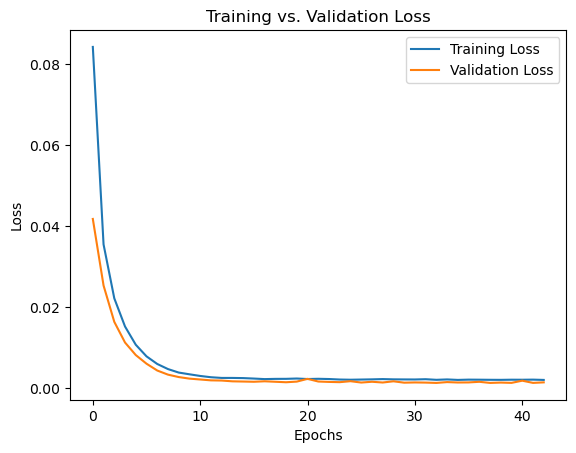

In [31]:

import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("Training vs. Validation Loss")
plt.show()


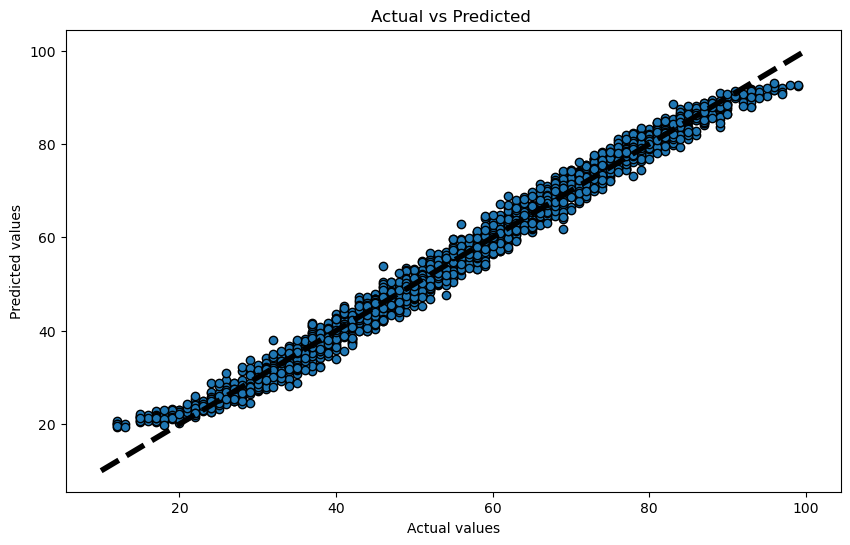

In [33]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, predictions_original, edgecolors=(0, 0, 0))
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Actual vs Predicted ')
plt.show()
